Import Libraries

In [278]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
from flax import nnx
from flax import struct
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Any

Hyper Parameters

In [279]:
Epochs = 1000
alpha = 1.0
gamma = 0.4
lambda_ = 0.1
Learn_Rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
Batch_size = 40
train_split = 0.9

Unpickling the data

In [280]:
# Due to errors I was experiencing this seems to be the quickest fix I could find to allow me to unpickle the data
import sys
import types
import pickle

fake_module = types.ModuleType("DataSetup")

class DataStore:
    def __init__(self):
        pass

fake_module.DataStore = DataStore

sys.modules["DataSetup"] = fake_module

data_file_1 = r"C:\Users\samue\Downloads\Simulation.pickle"
data_file_2 = r"C:\Users\samue\Downloads\Simulation 2.pickle"

with open(data_file_1,"rb") as f:
    data_unpickled_1 = pickle.load(f)

with open(data_file_2,"rb") as f:
    data_unpickled_2 = pickle.load(f)

_,data_object_1 = data_unpickled_1
_,data_object_2 = data_unpickled_2

input_dataset_1 = jnp.array(data_object_1.Indata)
#data_index_1 = data_object_1.i
e_dataset_1 = jnp.array(data_object_1.SE)
e_prime_dataset_1 = jnp.array(data_object_1.Jac)

input_dataset_2 = jnp.array(data_object_2.Indata)
#data_index_2 = data_object_2.i
e_dataset_2 = jnp.array(data_object_2.SE)
e_prime_dataset_2 = jnp.array(data_object_2.Jac)

input_dataset_2 = jnp.array(data_object_2.Indata)[0:2340]
e_dataset_2 = jnp.array(data_object_2.SE)[0:2340]
e_prime_dataset_2 = jnp.array(data_object_2.Jac)[0:2340]

print(input_dataset_2.shape)
print(input_dataset_1.shape)
print(e_dataset_1.shape)
print(e_prime_dataset_1.shape)

input_dataset = jax.numpy.concatenate([input_dataset_1,input_dataset_2],axis=0)
target_e_dataset = jax.numpy.concatenate([e_dataset_1, e_dataset_2],axis=0)
target_e_dataset = jax.numpy.expand_dims(target_e_dataset,axis=1)
target_e_prime_dataset = jax.numpy.concatenate([e_prime_dataset_1,e_prime_dataset_2],axis=0)

print(input_dataset.shape)
print(target_e_dataset.shape)
print(target_e_prime_dataset.shape)

(2340, 152, 3)
(10000, 152, 3)
(10000,)
(10000, 152, 3)
(12340, 152, 3)
(12340, 1)
(12340, 152, 3)


Redimensionalise

In [281]:
def Redimensionalise(self):
    self.Disp = jnp.zeros((self.Dims,self.Dims,self.Dims,3))
    m = 0
    for i in range(self.Dims):
        for j in range(self.Dims):
            for k in range(self.Dims):
                if self.xInMesh[0][i,j,k] == 0 or self.xInMesh[0][i,j,k] == 1 or self.xInMesh[1][i,j,k] == 0 or self.xInMesh[1][i,j,k] == 1 or self.xInMesh[2][i,j,k] == 0 or self.xInMesh[2][i,j,k] == 1:
                    self.Disp[i,j,k,:] = self.RandDisp[self.Index,m,:]
                    m = m +1
    return self.Disp
    

RNG key

In [282]:
seed = 42 # This can be changed but is here to make the results easy to reproduce
base_key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(base_key)

Pre and post processing functions

In [283]:
def mean_and_std_dev(data,*,train_split):
    split_idx = int(data.shape[0] * train_split)
    train_data = data[:split_idx]
    
    mean = jnp.mean(train_data, axis=0)
    std_dev = jnp.std(train_data, axis=0)
    return {'mean':mean, 'std_dev':std_dev}

def scale_data(data,*, data_params):
    return (data - data_params['mean']) / data_params['std_dev']
    

def unscale_data(data,*,data_params):
    return (data * data_params['std_dev']) + data_params['mean']

Dataset

In [284]:
batch_num = input_dataset.shape[0] // Batch_size

input_dataset = input_dataset.reshape((input_dataset.shape[0],456))
target_e_dataset = target_e_dataset.reshape((target_e_dataset.shape[0],))
target_e_prime_dataset = target_e_prime_dataset.reshape((target_e_prime_dataset.shape[0],456))

params_dict_displacement = mean_and_std_dev(input_dataset,train_split=train_split)
params_dict_target_e = mean_and_std_dev(target_e_dataset,train_split=train_split)
params_dict_target_e_prime = mean_and_std_dev(target_e_prime_dataset,train_split=train_split)

input_dataset_scaled = scale_data(input_dataset, data_params=params_dict_displacement)
target_e_dataset_scaled = scale_data(target_e_dataset, data_params=params_dict_target_e)
target_e_prime_dataset_scaled = scale_data(target_e_prime_dataset, data_params=params_dict_target_e_prime)

Dataset_parameters = {
    'displacements':params_dict_displacement,
    'target_e':params_dict_target_e,
    'target_e_prime':params_dict_target_e_prime
}

Dataset = {
    'displacements':input_dataset_scaled,
    'target_e':target_e_dataset_scaled,
    'target_e_prime':target_e_prime_dataset_scaled
}



print("INSPECTING RAW DATASET")
for key, value in Dataset.items():
    print(f"Key: '{key}'")
    print(f"  - Type: {type(value)}")
    if hasattr(value, 'shape'):
        print(f"  - Shape: {value.shape}")
    else:
        print("  - No shape attribute.")
    if hasattr(value, 'dtype'):
        print(f"  - Dtype: {value.dtype}")
print("------------------------------")


INSPECTING RAW DATASET
Key: 'displacements'
  - Type: <class 'jaxlib._jax.ArrayImpl'>
  - Shape: (12340, 456)
  - Dtype: float32
Key: 'target_e'
  - Type: <class 'jaxlib._jax.ArrayImpl'>
  - Shape: (12340,)
  - Dtype: float32
Key: 'target_e_prime'
  - Type: <class 'jaxlib._jax.ArrayImpl'>
  - Shape: (12340, 456)
  - Dtype: float32
------------------------------


In [285]:
print(Dataset['displacements'][0][1])
print(Dataset['target_e'][0])
print(Dataset['target_e_prime'][0][1])

1.1932328
2.932326
4.1916647


Node Classes and Acivations

In [286]:
class Linear(nnx.Module):
    """Linear node for neural network"""

    def __init__(self,din: int,dout: int,*,rngs: nnx.Rngs):
        key = rngs.params()
        self.W = nnx.Param(jax.random.uniform(key=key, shape=(din,dout)))
        self.b = nnx.Param(jnp.zeros(shape=(dout,)))
        self.din, self.dout = din, dout

    def __call__(self,x: jax.Array):
        return(x @ self.W + self.b)
    
def SiLU(x: jax.Array):
    """Sigmoid Weighted Linear Unit activation function"""
    return x * jax.nn.sigmoid(x)

Model Architecture

In [287]:
class energy_prediction(nnx.Module):
    """Model architecture"""

    def __init__(self,dim_in: int, dim_hidden1_in: int, dim_hidden2_in: int,dim_hidden3_in, dim_out: int,*,rngs: nnx.Rngs):
        self.layer1 = Linear(din=dim_in,dout=dim_hidden1_in,rngs=rngs)
        self.layer2 = Linear(din=dim_hidden1_in,dout=dim_hidden2_in,rngs=rngs)
        self.layer3 = Linear(din=dim_hidden2_in,dout=dim_hidden3_in,rngs=rngs)
        self.layer4 = Linear(din=dim_hidden3_in,dout=dim_out,rngs=rngs)
        self.silu = SiLU
        
    def __call__(self,x_in):
        # pass to calculate e
        def forwardPass(x):
            x = self.layer1(x)
            x = self.silu(x)
            x = self.layer2(x)
            x = self.silu(x)
            x = self.layer3(x)
            x = self.silu(x)
            x = self.layer4(x)
            return x.squeeze()
        
        e = jax.vmap(forwardPass)(x_in)
        dedx = jax.vmap(jax.grad(forwardPass,argnums=(0)))
        e_prime = dedx(x_in)

        return e, e_prime


Define optimiser and loss

In [288]:
optimiser = optax.adam(learning_rate=Learn_Rate, b1=beta_1, b2=beta_2)

def loss_fn(x: jax.Array, target_e, target_e_prime,*, Model,alpha,gamma,lam): 
    """
    Calculates the loss of a model, works to minimise the mean square error of both 
    the strain energy prediction and the strain energy derivative prediction,
    whilst forcing the function through zero.
    """
    
    prediction_e, prediction_e_prime = Model(x)
    loss_e = jnp.mean((prediction_e - target_e)**2)
    loss_e_prime = jnp.mean((prediction_e_prime - target_e_prime)**2)

    target_zero = 0
    x_zero = jnp.zeros(x[0].shape)
    x_zero = jnp.expand_dims(x_zero, axis=0)
    prediction_zero, _ = Model(x_zero)
    loss_zero = jnp.mean((prediction_zero - target_zero)**2)

    return (alpha * loss_e + gamma * loss_e_prime + lam * loss_zero)

Train State Bundle

In [289]:
@nnx.dataclass
class TrainState(nnx.Object):
    params: Any
    graph_def: Any 
    state: Any
    alpha: float 
    gamma: float 
    lambda_: float 

Train Step

In [290]:
@nnx.jit
def training_step(params,state,opt_state,batch,*,graph_def,alpha,gamma,lambda_):

    disp_in = batch['displacements']
    e_target = batch['target_e']
    e_prime_target = batch['target_e_prime']

    def wrapped_loss_fn(params_,state_):
        Model = nnx.merge(graph_def,params_,state_)
        loss = loss_fn(
            disp_in,
            e_target,
            e_prime_target,
            Model=Model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_
        )
        return loss

    loss, grads = nnx.value_and_grad(wrapped_loss_fn, argnums=0)(params, state) 
    updates, new_opt_state = optimiser.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    new_state = state

    return new_params, new_state, new_opt_state, loss

Batch Creator and test set creator

In [291]:
def split_and_batch_dataset(dataset, batch_size, test_split=0.2, shuffle=True):
    """
    Splits the dataset into training and test sets, then yields batches for each.
    Returns: (train_batches, test_batches).
    """
    N = dataset['displacements'].shape[0]
    indices = jnp.arange(N)
    if shuffle:
        indices = jax.random.permutation(jax.random.PRNGKey(0), indices)
    split_idx = int(N * (1 - test_split))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    def batch_indices(idx):
        batch_num = len(idx) // batch_size
        for i in range(batch_num):
            start = i * batch_size
            end = start + batch_size
            batch_idx = idx[start:end]
            batch = {key: value[batch_idx] for key, value in dataset.items()}
            yield batch

    train_batches = list(batch_indices(train_idx))
    test_batches = list(batch_indices(test_idx))
    return train_batches, test_batches

Create test and train batches

In [292]:
train_batches, test_batches = split_and_batch_dataset(
    Dataset, 
    Batch_size, 
    test_split=(1 - train_split), 
    shuffle=True
)

Training Loop

In [293]:
# Instantiate energy prediction NN
Model = energy_prediction(
    dim_in=input_dataset.shape[1], 
    dim_hidden1_in=1024,
    dim_hidden2_in=512,
    dim_hidden3_in=256, 
    dim_out=1,
    rngs=rngs
)

graph_def,params,state = nnx.split(Model,nnx.Param,nnx.State)
opt_state = optimiser.init(params)

train_state = TrainState(
    graph_def=graph_def,
    params=params,
    state=state,
    alpha=alpha,
    gamma=gamma,
    lambda_=lambda_
    )

loss_record = []

for epoch in range(Epochs):
    running_loss = 0.0
    batch_count = 0

    for batch in tqdm(train_batches,desc=f"Epoch {epoch}/{Epochs}", leave=False):
        
        new_params, new_state, new_opt_state, loss_batch = training_step(
            train_state.params,
            train_state.state,
            opt_state,
            batch,
            graph_def=train_state.graph_def,
            alpha=train_state.alpha,
            gamma=train_state.gamma,
            lambda_=train_state.lambda_
        )

        opt_state = new_opt_state
        train_state.params = new_params
        train_state.state = new_state

        running_loss += loss_batch
        batch_count += 1
    
    avg_loss = avg_loss = running_loss / batch_count if batch_count > 0 else 0.0
    loss_record.append(avg_loss)

KeyboardInterrupt: 

Final model storage

In [ ]:
@nnx.dataclass
class ModelData(nnx.Object):
    graph_def: Any
    params: Any
    state: Any
    trained: bool

Create Final model instance

In [ ]:
graph_def_trained = train_state.graph_def
params_trained = train_state.params
state_trained = train_state.state

model_data = ModelData(
    graph_def=graph_def_trained,
    params=params_trained,
    state = state_trained,
    trained=True
)

Plots

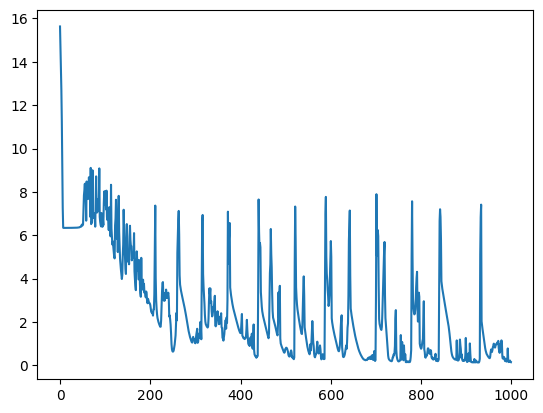

In [ ]:
plt.plot(jnp.log10(jnp.array(loss_record)))
#plt.plot(loss_record)

Model Testing

In [ ]:
def avg_abs_error(pred,target):
    n1 = pred.shape[0]
    n2 = target.shape[0]

    if n1 != n2:
        raise("Error: inputs must have matching shape")
    
    return (jnp.sum(jnp.abs(pred - target)) / n1)

def test_model(model_data, test_batches, Dataset_parameters,*,loss_fn, alpha, gamma, lambda_):

    trained = model_data.trained
    if not trained:
        raise TypeError("Model is untrained, please train the model before evaluation")

    test_graph_def = model_data.graph_def
    test_params = model_data.params
    test_state = model_data.state

    test_model = nnx.merge(test_graph_def,test_params,test_state)

    loss_test = 0.0
    test_count = 0

    for batch in test_batches:
        displacements_test = batch['displacements']
        e_target_test = batch['target_e']
        e_prime_target_test = batch['target_e_prime']

        e_target_test = unscale_data(e_target_test,data_params=Dataset_parameters['target_e'])
        e_prime_target_test = unscale_data(e_prime_target_test,data_params=Dataset_parameters['target_e_prime'])

        e_pred_test, e_prime_pred_test = test_model(displacements_test)

        e_pred_test = unscale_data(e_pred_test,data_params=Dataset_parameters['target_e'])
        e_prime_pred_test = unscale_data(e_prime_pred_test,data_params=Dataset_parameters['target_e_prime'])

        batch_loss_test = loss_fn(
            displacements_test,
            e_target_test,
            e_prime_target_test,
            Model=test_model,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_
        )

        loss_test += batch_loss_test
        test_count += 1

        avg_e_abs_error = avg_abs_error(e_pred_test,e_target_test)
        avg_e_prime_abs_error = avg_abs_error(e_prime_pred_test,e_prime_target_test)

    avg_loss_test = loss_test / test_count
    zero_val_e, _ = test_model(jnp.zeros_like(test_batches[0]['displacements']))
    test_e_zero_error = avg_abs_error(zero_val_e, jnp.zeros_like(zero_val_e))

    return avg_loss_test, avg_e_abs_error, avg_e_prime_abs_error, test_e_zero_error



Test

In [ ]:
avg_loss_test, avg_e_abs_error, avg_e_prime_abs_error, test_e_zero_error = test_model(model_data,test_batches, Dataset_parameters,loss_fn=loss_fn,alpha=alpha,gamma=gamma,lambda_=lambda_)
print(f"The average loss across the training set is {avg_loss_test}") 
print(f"The average absolute error for e is {avg_e_abs_error}") 
print(f"the average absolute error for e prime is {avg_e_prime_abs_error}") 
print(f"the absolute zero error for e is {test_e_zero_error}") 

ZeroDivisionError: float division by zero